In [41]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import pandas as pd
import seaborn as sns

def shrink(x):
    return torch.nn.functional.interpolate(
        torch.Tensor(x).unsqueeze(0).unsqueeze(0), scale_factor=0.5,
        recompute_scale_factor=True)[0][0].numpy()

In [42]:
# file_gt = '/home/anna/data_19Nov2022/real_test.h5'
# file_gt_en = '/home/anna/ResultsSignalDA/MIAvalidation_olddataset/Benchmark_MultiGT_EN/Reconstructions/arm_linear_sigmat_multisegment/arm_linear_sigmat_multisegment.h5'
# file_linbm_en = '/home/anna/ResultsSignalDA/MIAvalidation_olddataset/Benchmark_LinearGT_EN/Reconstructions/arm_linear_sigmat_multisegment/arm_linear_sigmat_multisegment.h5'

# Ground truth

Back projection

In [97]:
# file_gt_bp = '/home/anna/dlbirhoui_data/arm.h5'
file_gt_bp = '/home/anna/ResultsSignalDA/MIAvalidation_olddataset/Benchmark_MultiGT_BP//Reconstructions/arm_multi_sigmat_multisegment///arm_multi_sigmat_multisegment.h5'
# file_gt_bp = '/home/anna/dlbirhoui_data//Reconstructions/arm_multi_sigmat_multisegment//arm_multi_sigmat_multisegment.h5'
gt_rec_bp = h5py.File(file_gt_bp, 'r')
multi_GT_bp = gt_rec_bp['BackProjection']
print(multi_GT_bp.shape)

# file_gt_bp_lin = '/home/anna/dlbirhoui_data//Reconstructions/arm_linear_sigmat_multisegment//arm_linear_sigmat_multisegment.h5'
file_gt_bp_lin = '/home/anna/ResultsSignalDA/MIAvalidation_olddataset/Benchmark_LinearGT_BP//Reconstructions/arm_linear_sigmat_multisegment//arm_linear_sigmat_multisegment.h5'

gt_rec_bp_lin = h5py.File(file_gt_bp_lin, 'r')
linear_GT_bp = gt_rec_bp_lin['BackProjection']
print(linear_GT_bp.shape)


(5565, 256, 256)
(5565, 256, 256)


In [44]:
gt_old = '/home/anna/dlbirhoui_data/arm.h5'
gt_old_rec = h5py.File(gt_old, 'r')
GT_old_rec = gt_old_rec['recon_multisegment']

Elsastic Net

In [45]:
file_gt_en = '/home/anna/ResultsSignalDA/MIAvalidation_olddataset/Benchmark_MultiGT_EN/Reconstructions/arm_multi_sigmat_multisegment/arm_multi_sigmat_multisegment.h5'
gt_rec_en = h5py.File(file_gt_en, 'r')
multi_GT_en = gt_rec_en['ElasticNet 1e-5']

file_linbm_en = '/home/anna/ResultsSignalDA/MIAvalidation_olddataset/Benchmark_LinearGT_EN/Reconstructions/arm_linear_sigmat_multisegment/arm_linear_sigmat_multisegment.h5'
linbm_rec_en = h5py.File(file_linbm_en, 'r')
linear_GT_en = linbm_rec_en['ElasticNet 1e-5']

# UNet from Firat

In [84]:
# filetgt = h5py.File('/home/anna/OptoAcoustics/data/benchmark_invivo.h5', 'r')
# tgt_exmpls = []
# for i in range(32):
#     tgt_exmpls.append(filetgt['img_num'][i][0])
#     print(filetgt['img_num'][i][0])
    
# print(tgt_exmpls)


In [47]:
## run in case you need to resave the model
# model = 'unet_ellipsesSkinMask_20210412_lin2Ms_scaleclip_MAE'
# file = h5py.File(f'/home/firat/docs/dlbirhoui/parsed_data/armBP_mapping_from_linear.h5', 'r')[model]['recon_multisegment']

# tgt_folder = f'/home/anna/ResultsSignalDA/UNet/'

# nimgs = 5565
# sigmat_size = [256, 256]    
# compression_lvl = 9 # pick between 0 and 9

# # modes_list = ['BackProjection']
# fname_h5 = f'{tgt_folder}/{model}.h5'

# modes_list = ['BackProjection', 'ElasticNet 1e-5']
# print('Creating file: %s' % fname_h5)
# data = {}
# with h5py.File(fname_h5, 'w', libver='latest') as h5_fh:
#     for mode in modes_list:
#         data[mode] =\
#             h5_fh.create_dataset(mode,
#             shape=[nimgs] + sigmat_size, 
#             dtype=np.float32, chunks=tuple([1] + sigmat_size),
#             compression='gzip', compression_opts=compression_lvl)

# with h5py.File(fname_h5, 'a', libver='latest') as h5_fh:
#     for i in range(nimgs):
#         x = shrink(file[i])
#         for mode in modes_list:            
#             h5_fh[mode][i] = x
            

In [85]:
# file_unet = '/home/anna/ResultsSignalDA/UNet//unet_ellipsesSkinMask_20210412_lin2Ms_scaleclip_MAE.h5'
file_unet = '/home/anna/OptoAcoustics//MIDL/from_firat_1024//unet_ellipsesSkinMask_20210412_lin2Ms_scaleclip_MAE.h5'
f_unet = h5py.File(file_unet, 'r')
unet = f_unet['BackProjection']
# unet = gt_rec_en['ElasticNet 1e-5']

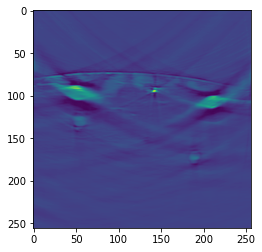

In [89]:
i = np.random.choice(5)
plt.imshow(unet[i])

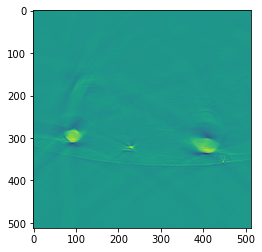

In [90]:
plt.imshow(GT_old_rec[i])

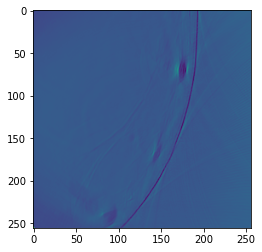

In [91]:
plt.imshow(multi_GT_bp[i])

# Metrics

In [51]:
folder_rec = '/home/anna/ResultsSignalDA/MIAvalidation_olddataset/reconstruction//MIAstyleLinear__2022-12-09/'

In [52]:
batch = 0
file_input = f'{folder_rec}/Reconstructions/real_{batch}_multi_signal_with_RC/real_{batch}_multi_signal_with_RC.h5'

rec = h5py.File(file_input, 'r')
rec_bp = rec['BackProjection']
rec_en = rec['ElasticNet 1e-5']

In [92]:
def scale(im):
    sorted_int_values = np.sort(np.reshape(im, [-1]))
    low5, high95 = int(len(sorted_int_values) * 0.025), int(len(sorted_int_values) * 0.975)
    im_clipped = np.clip(im, a_min=sorted_int_values[low5], a_max=sorted_int_values[high95])
    im_clipped = im
    im_clipped /= np.max(im_clipped)
    im_clipped = np.clip(im_clipped, -0.2, 2)
    return im_clipped

In [93]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
import cv2

def get_metrics(gt, pred):
    metrics = {}
    metrics['SSIM'] = ssim(pred, gt, data_range=gt.max() - gt.min())
    metrics['PSNR'] = cv2.PSNR(gt, pred)
    metrics['MAE'] = np.mean(abs(gt - pred))
    metrics['RMSE'] = mean_squared_error(gt, pred)
    metrics['Pearson'] = pearsonr(gt.reshape(-1), pred.reshape(-1))[0]
    metrics['Spearman'] = 0 #r2_score(gt.reshape(-1), pred.reshape(-1))[0]
    
    return metrics

In [94]:
def get_images(i, batch, plot=False):
    gt_old = np.rot90(scale(shrink(GT_old_rec[batch*256+i])), 2)
    
    gt_en = scale(multi_GT_en[batch*256+i])
    gt_lin_en = scale(linear_GT_en[batch*256+i])
    gt_bp = scale(multi_GT_bp[batch*256+i])
    gt_lin_bp = scale(linear_GT_bp[batch*256+i])
    
    unet_bp = scale(unet[batch*256+i])
    
    gt_en = np.rot90(gt_en)[:, ::-1]
    gt_lin_en = np.rot90(gt_lin_en)[:, ::-1]
    
    gt_bp = scale(np.rot90(gt_bp)[:, ::-1])
    gt_lin_bp = scale(np.rot90(gt_lin_bp)[:, ::-1])
    
    en = scale(np.rot90(rec_en[i])[:, ::-1])
    bp = scale(np.rot90(rec_bp[i])[:, ::-1])
        
    if plot:
        fig, axs = plt.subplots(2, 4, figsize=(10,4))
        axs[0, 0].imshow(gt_bp)
        axs[0, 0].set_title('GT')
        axs[0, 1].imshow(gt_lin_bp)
        axs[0, 1].set_title('GT linear')
        
        axs[1, 0].imshow(gt_en)
        # axs[1, 0].set_title('GT')
        axs[1, 1].imshow(gt_lin_en)
        # axs[1, 1].set_title('GT linear')
        
        axs[1, 2].imshow(en)
        axs[1, 2].set_title('EN')
        axs[0, 2].imshow(bp)
        axs[0, 2].set_title('BP')
        
        axs[0, 3].imshow(unet_bp)
        axs[0, 3].set_title('UNet')
        axs[1, 3].imshow(gt_old)
        # axs[1, 3].set_title('Unet')
    
    metrics_en = get_metrics(gt_en, en)
    metrics_bp = get_metrics(gt_bp, bp)
    metrics_lin_en = get_metrics(gt_en, gt_lin_en)
    metrics_lin_bp = get_metrics(gt_bp, gt_lin_bp)
    
    metrics_unet = get_metrics(gt_old, unet_bp)
    
    return metrics_en, metrics_bp, metrics_lin_bp, metrics_lin_en, metrics_unet

In [99]:
metrics_en_total = {'SSIM': [], 'PSNR': [], 'MAE': [], 'RMSE': [], 'Pearson': [], 'Spearman': []}
metrics_bp_total = {'SSIM': [], 'PSNR': [], 'MAE': [], 'RMSE': [], 'Pearson': [], 'Spearman': []}
metrics_lin_bp_total = {'SSIM': [], 'PSNR': [], 'MAE': [], 'RMSE': [], 'Pearson': [], 'Spearman': []}
metrics_lin_en_total = {'SSIM': [], 'PSNR': [], 'MAE': [], 'RMSE': [], 'Pearson': [], 'Spearman': []}
metrics_unet_total = {'SSIM': [], 'PSNR': [], 'MAE': [], 'RMSE': [], 'Pearson': [], 'Spearman': []}

n_batches = 4 #22
for batch in range(n_batches):
# batch = np.random.choice(n_batches)
    file_input = f'{folder_rec}/Reconstructions/real_{batch}_multi_signal_with_RC/real_{batch}_multi_signal_with_RC.h5'
    rec = h5py.File(file_input, 'r')
    rec_bp = rec['BackProjection']
    rec_en = rec['ElasticNet 1e-5']
    n = rec_en.shape[0]
    # n = 256
    pbar = tqdm(range(n))
    for i in pbar:
        metrics_en, metrics_bp, metrics_lin_bp, metrics_lin_en, metrics_unet = get_images(i, batch, False)
        for k in metrics_en:
            metrics_en_total[k].append(metrics_en[k])
            metrics_bp_total[k].append(metrics_bp[k])
            metrics_lin_bp_total[k].append(metrics_lin_bp[k])
            metrics_lin_en_total[k].append(metrics_lin_en[k])
            metrics_unet_total[k].append(metrics_unet[k])
        pbar.set_description(f"[{batch}]: SSIM_en={np.mean(metrics_en_total['SSIM']):.2f}, \
            SSIM_bm_en={np.mean(metrics_lin_en_total['SSIM']):.2f}, \
                SSIM_bp={np.mean(metrics_lin_bp_total['SSIM']):.2f}, \
                    SSIM_unet={np.mean(metrics_unet_total['SSIM']):.2f}, \
                        SSIM_bm_bp={np.mean(metrics_lin_bp_total['SSIM']):.2f}")

[0]: SSIM_en=0.87,             SSIM_bm_en=0.82,                 SSIM_bp=0.63,                     SSIM_unet=0.62,                         SSIM_bm_bp=0.63: 100%|██████████| 256/256 [00:57<00:00,  4.45it/s]
[1]: SSIM_en=0.87,             SSIM_bm_en=0.81,                 SSIM_bp=0.62,                     SSIM_unet=0.63,                         SSIM_bm_bp=0.62: 100%|██████████| 256/256 [00:59<00:00,  4.33it/s]
[2]: SSIM_en=0.87,             SSIM_bm_en=0.81,                 SSIM_bp=0.62,                     SSIM_unet=0.61,                         SSIM_bm_bp=0.62: 100%|██████████| 256/256 [01:02<00:00,  4.12it/s]
[3]: SSIM_en=0.87,             SSIM_bm_en=0.81,                 SSIM_bp=0.62,                     SSIM_unet=0.62,                         SSIM_bm_bp=0.62: 100%|██████████| 256/256 [00:59<00:00,  4.28it/s]


In [100]:
len(metrics_lin_bp_total['SSIM'])

1024

In [101]:
print('Elastic Net')
for k in metrics_en_total:
    m, s = np.mean(metrics_en_total[k]), np.std(metrics_en_total[k])
    print(f'{k}: {m:.3f} +/- {s:.3f}')
    
print('\nBackProjection')
for k in metrics_bp_total:
    m, s = np.mean(metrics_bp_total[k]), np.std(metrics_bp_total[k])
    print(f'{k}: {m:.3f} +/- {s:.3f}')
    
print('\nLinear BP')
for k in metrics_bp_total:
    m, s = np.mean(metrics_lin_bp_total[k]), np.std(metrics_lin_bp_total[k])
    print(f'{k}: {m:.3f} +/- {s:.3f}')
    
print('\nLinear EN')
for k in metrics_lin_en_total:
    m, s = np.mean(metrics_lin_en_total[k]), np.std(metrics_lin_en_total[k])
    print(f'{k}: {m:.3f} +/- {s:.3f}')
    
print('\nUNet')
for k in metrics_unet_total:
    m, s = np.mean(metrics_unet_total[k]), np.std(metrics_unet_total[k])
    print(f'{k}: {m:.3f} +/- {s:.3f}')

Elastic Net
SSIM: 0.869 +/- 0.060
PSNR: 75.901 +/- 2.851
MAE: 0.011 +/- 0.005
RMSE: 0.002 +/- 0.001
Pearson: 0.748 +/- 0.130
Spearman: 0.000 +/- 0.000

BackProjection
SSIM: 0.603 +/- 0.115
PSNR: 76.414 +/- 2.760
MAE: 0.025 +/- 0.012
RMSE: 0.002 +/- 0.002
Pearson: 0.812 +/- 0.064
Spearman: 0.000 +/- 0.000

Linear BP
SSIM: 0.620 +/- 0.111
PSNR: 76.671 +/- 2.789
MAE: 0.025 +/- 0.011
RMSE: 0.002 +/- 0.002
Pearson: 0.828 +/- 0.054
Spearman: 0.000 +/- 0.000

Linear EN
SSIM: 0.806 +/- 0.081
PSNR: 74.919 +/- 2.199
MAE: 0.014 +/- 0.006
RMSE: 0.002 +/- 0.001
Pearson: 0.683 +/- 0.117
Spearman: 0.000 +/- 0.000

UNet
SSIM: 0.624 +/- 0.077
PSNR: 75.723 +/- 1.753
MAE: 0.023 +/- 0.005
RMSE: 0.002 +/- 0.001
Pearson: 0.750 +/- 0.041
Spearman: 0.000 +/- 0.000


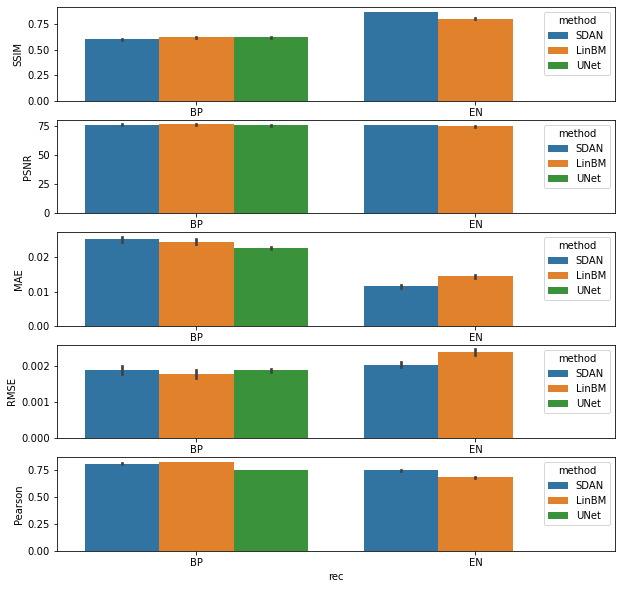

In [102]:
df_bp = pd.DataFrame.from_dict(metrics_bp_total)
df_bp['method'] = 'SDAN'
df_bp['rec'] = 'BP'

df_en = pd.DataFrame.from_dict(metrics_en_total)
df_en['method'] = 'SDAN'
df_en['rec'] = 'EN'

df_bp_linbm = pd.DataFrame.from_dict(metrics_lin_bp_total)
df_bp_linbm['method'] = 'LinBM'
df_bp_linbm['rec'] = 'BP'

df_en_linbm = pd.DataFrame.from_dict(metrics_lin_en_total)
df_en_linbm['method'] = 'LinBM'
df_en_linbm['rec'] = 'EN'

df_unet = pd.DataFrame.from_dict(metrics_unet_total)
df_unet['method'] = 'UNet'
df_unet['rec'] = 'BP'
df = pd.concat([df_bp, df_en, df_bp_linbm, df_en_linbm, df_unet]).reset_index()

methods = ['SSIM', 'PSNR', 'MAE', 'RMSE', 'Pearson']

fig, ax = plt.subplots(len(methods), 1, figsize=(10,10))

for i,m in enumerate(methods):
    sns.barplot(data=df, x="rec", y=m, ax=ax[i], hue="method")


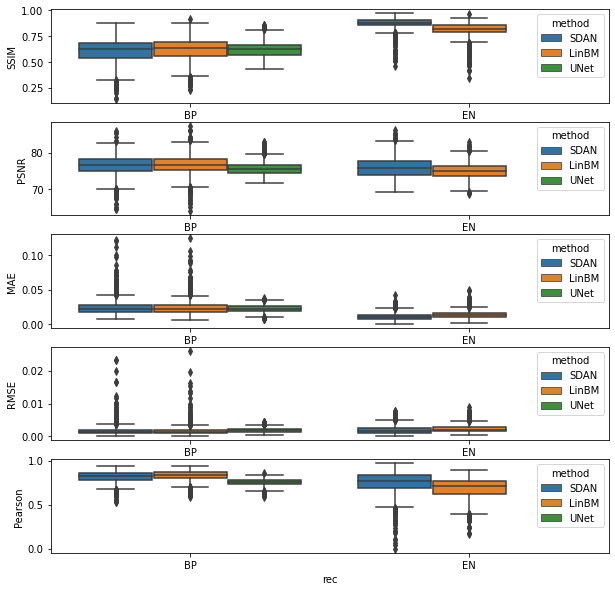

In [103]:
fig, ax = plt.subplots(len(methods), 1, figsize=(10,10))


for i,m in enumerate(methods):
    sns.boxplot(data=df, x="rec", y=m, ax=ax[i], hue="method")

In [64]:
df.groupby(['method', 'rec']).mean().sort_values('PSNR', ascending=False).style.format('{:.4f}')

,,index,SSIM,PSNR,MAE,RMSE,Pearson,Spearman
method,rec,,,,,,,
LinBM,BP,2782.0000,0.6527,77.7677,0.0214,0.0014,0.8333,0.0000
SDAN,BP,2782.0000,0.6331,77.4290,0.0222,0.0015,0.8129,0.0000
UNet,BP,2782.0000,0.6549,76.5111,0.0206,0.0016,0.7481,0.0000
SDAN,EN,2782.0000,0.8764,76.3354,0.0108,0.0018,0.7483,0.0000
LinBM,EN,2782.0000,0.8099,75.2526,0.0142,0.0023,0.6875,0.0000


({'SSIM': 0.9225638472117622,
  'PSNR': 80.67343849152505,
  'MAE': 0.0059674853,
  'RMSE': 0.0005568478056732621,
  'Pearson': 0.8850738416538786,
  'Spearman': 0},
 {'SSIM': 0.6582578251336939,
  'PSNR': 77.45861830763047,
  'MAE': 0.020439379,
  'RMSE': 0.0011673968858108904,
  'Pearson': 0.8610191378620006,
  'Spearman': 0},
 {'SSIM': 0.6326081465494791,
  'PSNR': 76.10637874041456,
  'MAE': 0.022377305,
  'RMSE': 0.0015938318001597102,
  'Pearson': 0.8252847887013612,
  'Spearman': 0},
 {'SSIM': 0.82472842410248,
  'PSNR': 73.81724561577545,
  'MAE': 0.014803197,
  'RMSE': 0.0026999504938504024,
  'Pearson': 0.6135266201318726,
  'Spearman': 0},
 {'SSIM': 0.6461459733395851,
  'PSNR': 77.27222954690303,
  'MAE': 0.018704446,
  'RMSE': 0.0012185894307139853,
  'Pearson': 0.7908810086328223,
  'Spearman': 0})

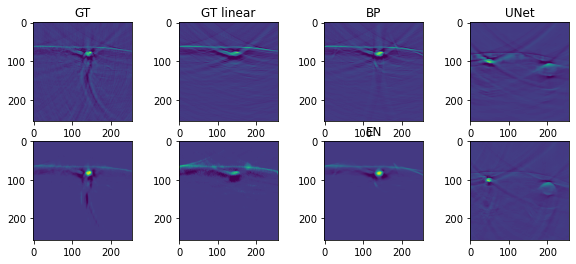

In [104]:
batch = np.random.choice(1)
i = np.random.choice(32)

file_input = f'{folder_rec}/Reconstructions/real_{batch}_multi_signal_with_RC/real_{batch}_multi_signal_with_RC.h5'
rec = h5py.File(file_input, 'r')
rec_bp = rec['BackProjection']
rec_en = rec['ElasticNet 1e-5']
    
get_images(i, batch, True)